Now I have to generate the ground truth for my approach

In this notebook I tried to obtain the density maps for the images I have at disposal. So basically I read the files with the position of the kernels in each image, generate a numpy array marking their position and then i perform a convolution with a gaussian filter.

At the end I get a numpy array which is the density map. This is a 2 dimensional array which could be interpreted as a single channel image and thats the way I want to save it for further usage in the network training. 
The problem arises when I try to upload the image to check its content, somehow it became into an RGB image, as I want to keep some control over the image because I need the maps for estimating the number of kernels I want to keep the grayscale.
So what I did was:
- Normalize the map so the sum is one
- move the interval of the data to [0,255] which is grayscale in order to avoid having so many values close to one which may cause gradient vanishing problems.

in this way I keep some control over the shape of the images and also on the values. Because now I know how to invert the map so to obtain the right count.

In [1]:
### IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2
#from PIL import Image

In [2]:
def get_image_relevant_data(df_info, df_positions,id_):
#     if (id_ >= len(df_info)): 
#         print("THIS ID IS NOT CONTAINED IN THE DATASET")
#         return
    
    shape =[df_info[df_info['id'] == id_].reset_index()["height"][0],
            df_info[df_info['id'] == id_].reset_index()["width"][0]]
    kernel_number = df_info[df_info['id'] == id_].reset_index()["counts"][0]
    file_name = df_info[df_info['id'] == id_].reset_index()["file_name"][0]

    kernel_positions = df_positions[df_positions['image_id'] == id_][["kernel_x","kernel_y"]].to_numpy()    
    return kernel_positions, shape, kernel_number,file_name

In [3]:
def generate_label(label_info, image_shape,sig=1):
    """
    Generate a density map based on objects positions.
    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated
    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    # note: *_ because some datasets contain more info except x, y coordinates
    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 1

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(sig, sig), order=0)

    return label

In [5]:
### PARAMETER
sigma = 12
enlargement = 1

In [6]:
root_path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"
maxim = []
for dataset in ["narrow","many","corn"]:
    for mode in ["train","test"]:
        df_i = pd.read_csv (root_path + f"{dataset}_coco/{dataset}_kernel_{mode}_info.csv" )
        df_p = pd.read_csv (root_path + f"{dataset}_coco/{dataset}_kernel_{mode}_positions.csv" )       

        ### Loop over all the images in the dataset
        for im in list(df_i["id"]):
            ### Get the information
            kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
            ### Produce the maps
            image = generate_label(kernel_positions, shape,sigma)
            ### Threshold image
            image[image<=1e-4]=0
            ### nomarlize map
            image=image/image.sum()*kernel_number
            ### Save map
            path_map = root_path + f"{dataset}_coco/" +file[:-4]+"_map.tiff"
            cv2.imwrite(path_map,image) 
            
            ### just for the sake of cheking the number of kernels
            #print("Annotated kernels","Feature kernels")
            #print(kernel_number,int(np.sum(image)))
            maxim.append(np.max(image)/enlargement)

In [13]:
image[image<=1e-4]=0

In [19]:
image=image/image.sum()*kernel_number

In [20]:
kernel_number

36

In [21]:
image.sum()

36.0

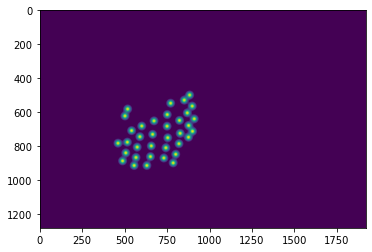

In [24]:
plt.imshow(image)#.sum()

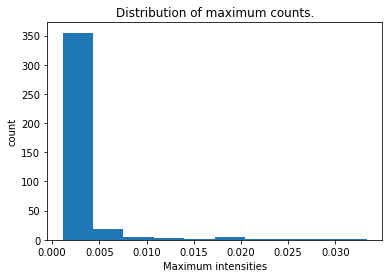

In [6]:
plt.hist(maxim)
plt.xlabel("Maximum intensities")
plt.ylabel("count")
plt.title("Distribution of maximum counts.")
plt.show()

In this plot we can observe the distribution of the maximum values, just a few images have pixels reaching the 1e-2 value.
Notice that before producing the plot I divided it by the enlargement factor.

This plot help us to identify which could be a good enlargement factor, in order to avoid having too many values close to zero. 

**Lets check the pixel value distribution** 

In [7]:
long = np.reshape(image,newshape=image.shape[0]* image.shape[1])
tot = len(long)
n0 = np.count_nonzero(long ==0.)/tot
n6 = np.count_nonzero(np.logical_and(long>0,long<1e-6))/tot
n5 = np.count_nonzero(np.logical_and(long>1e-6,long<1e-5))/tot
n4 = np.count_nonzero(np.logical_and(long>1e-5,long<1e-4))/tot
n3 = np.count_nonzero(np.logical_and(long>1e-4,long<1e-3))/tot
n33 = np.count_nonzero(long >1e-3)/tot
hst = [n0,n6,n5,n4,n3,n33]

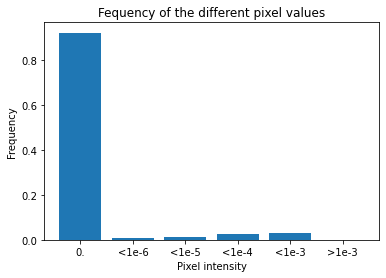

In [8]:
plt.bar([1,2,3,4,5,6],hst)
plt.title("Fequency of the different pixel values")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
labels = ["0.", "<1e-6", "<1e-5","<1e-4","<1e-3",">1e-3"]
plt.xticks([1,2,3,4,5,6], labels)
plt.show()

# For the new dataset

In [9]:
### PARAMETER
sigma = 12
enlargement = 1

In [10]:
root_path =  "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn2/corn_seed_counting_train_v2_clean/"
dataset = "new"
mode = "train"
df_i = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_info.csv" )
df_p = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_positions.csv" )


### Loop over all the images in the dataset
for im in list(df_i["id"]):
    ### Get the information
    kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
    ### Produce the maps
    image = generate_label(kernel_positions, shape,sigma)
    image *= enlargement
    ### Save map
    path_map = root_path + file[:-4]+"_map.tiff"
    # Save image
    cv2.imwrite(path_map,image)
    

I know that the enlargement factor may produce a saturation of the image so I want to check the effect for the format tiff of the images that should be preserving the numbers unchanged.

In [4]:
root_path =  "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn2/corn_seed_counting_train_v2_clean/"
sigma = 5
dataset = "new"
mode = "train"
df_i = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_info.csv" )
df_p = pd.read_csv (root_path + f"{dataset}_kernel_{mode}_positions.csv" )

In [5]:
mse = []
for enlargement in [1.,1e2,1e3,1e4,1e5]:
    map_1 = []
    map_2 = []
    ### Loop over all the images in the dataset
    for im in list(df_i["id"]):
        ### Get the information
        kernel_positions, shape, kernel_number, file = get_image_relevant_data(df_i, df_p, im)
        ### Produce the maps
        image = generate_label(kernel_positions, shape,sigma)
        image *= enlargement

        path_map = root_path + file[:-4]+"_map.tiff"
        # Save image
        cv2.imwrite(path_map,image)
        # Read image
        read_image = cv2.imread(path_map,flags=cv2.IMREAD_ANYDEPTH)
        
        map_1.append(image.sum()/enlargement)
        map_2.append(read_image.sum()/enlargement)
    mse.append(((np.array(map_1)-np.array(map_2))**2).mean())
    

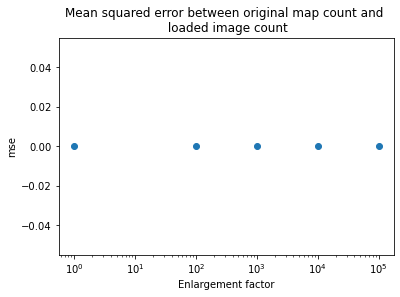

In [15]:
plt.scatter([1.,1e2,1e3,1e4,1e5],mse)
plt.xscale("log")
plt.xlabel("Enlargement factor")
plt.ylabel("mse")
plt.title("Mean squared error between original map count and \n loaded image count")
plt.show()

As we can see from the above plot there is no difference between the count from both images, so in theory we could expand the values of the maps as much as we want and we wont loose information as was the case with the grayscale where the values above 255 where all converted to 255.

In [11]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
read_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Observe that both, the original map and the loaded image are arrays of type float32